In [1]:
import os
os.chdir("..")
os.getcwd()

'c:\\Users\\ADEGOKE\\Desktop\\Hybrid-Video-Recommender-System'

## Load the 1M Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline 
warnings.filterwarnings("ignore")

df_ratings = pd.read_csv("data/raw/ratings.dat", sep="::", engine="python",
                      names=["user_id", "movie_id", "rating", "timestamp"])

df_movies = pd.read_csv("data/raw/movies.dat", sep="::", engine="python",
                     names=["movie_id", "title", "genres"], encoding="latin-1")


In [3]:
df_ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
df_movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### Check for missing values

In [5]:
df_ratings.isnull().sum()

user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64

In [6]:
df_ratings.shape

(1000209, 4)

In [7]:
df_movies.isnull().sum()

movie_id    0
title       0
genres      0
dtype: int64

In [8]:
df_movies.shape

(3883, 3)

### Check for unique values

In [9]:
df_ratings["user_id"].nunique(), df_ratings["movie_id"].nunique()

(6040, 3706)

In [10]:
df_movies["movie_id"].nunique()

3883

In [11]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [12]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [13]:
df_ratings["rating"].value_counts(normalize=True)

rating
4    0.348898
3    0.261142
5    0.226263
2    0.107535
1    0.056162
Name: proportion, dtype: float64

In [14]:
n_users = df_ratings.user_id.nunique()
n_items = df_ratings.movie_id.nunique()
density = len(df_ratings) / (n_users * n_items)

if density < 0.01:
    msg = "Excellent sparsity for ALS"
elif density < 0.05:
    msg = "Good sparsity for ALS MovieLens 1M range"
elif density < 0.10:
    msg = "Moderate sparsity - consider memory optimization"
else:
    msg = "High density - consider alternative algorithms"

print(msg)
density

Good sparsity for ALS MovieLens 1M range


0.044683625622312845

### EDA

In [15]:
# Calculate User Activity
user_counts = df_ratings.groupby("user_id").size()
print("User Activity Summary:")
print(f"Total Users: {len(user_counts):.1f}")
print(f"Mean Interaction per User: {user_counts.mean():.1f}")
print(f"Median Interaction per User: {user_counts.median():.1f}")
print(f"Standard Deviation of Interactions: {user_counts.std():.1f}")
print(f"Minimun Interactions: {user_counts.min():.1f}")
print(f"Maximun Interactions: {user_counts.max():.1f}")

# For ALS decisions
print(f"\nALS Considerations:")
print(f"User with < 5 interactions: {(user_counts < 5).sum()} ({(user_counts < 5).sum()/len(user_counts)*100:.1f}%)")
print(f"User with < 10 interactions: {(user_counts < 10).sum()} ({(user_counts < 10).sum()/len(user_counts)*100:.1f}%)")

User Activity Summary:
Total Users: 6040.0
Mean Interaction per User: 165.6
Median Interaction per User: 96.0
Standard Deviation of Interactions: 192.7
Minimun Interactions: 20.0
Maximun Interactions: 2314.0

ALS Considerations:
User with < 5 interactions: 0 (0.0%)
User with < 10 interactions: 0 (0.0%)


Text(0.5, 1.0, 'Complementary CDF')

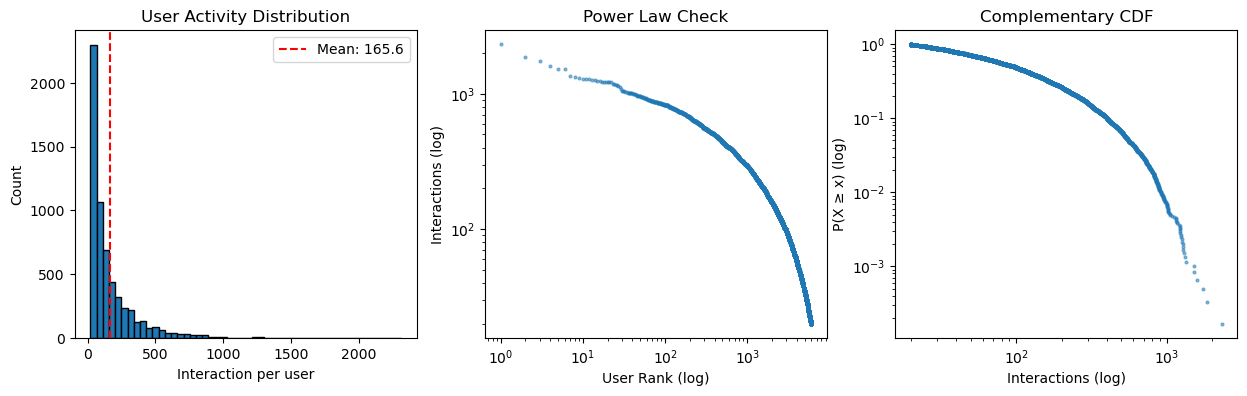

In [16]:
sorted_counts = user_counts.sort_values(ascending=False).reset_index(drop=True)

# Plot 1: Histogram
fig, axes = plt.subplots(1, 3, figsize = (15, 4))
axes[0].hist(user_counts, bins = 50, edgecolor = "black")
axes[0].set_xlabel("Interaction per user")
axes[0].set_ylabel("Count")
axes[0].set_title("User Activity Distribution")
axes[0].axvline(user_counts.mean(), color = "red", linestyle = "--", label = f"Mean: {user_counts.mean():.1f}")
axes[0].legend()

# Plot 2: Log-log plot for power law check
axes[1].loglog(sorted_counts.index + 1, sorted_counts.values, "o", alpha=0.5, markersize=2)
axes[1].set_xlabel("User Rank (log)")
axes[1].set_ylabel("Interactions (log)")
axes[1].set_title("Power Law Check")

# Plot 3: Complementary CDF
# ccdf = 1 - np.arange(len(sorted_counts)) / len(sorted_counts)
# axes[2].loglog(sorted_counts.values, ccdf, "o", alpha=0.5, markersize=2)
sorted_asc = np.sort(user_counts)
ccdf = 1.0 - np.arange(len(sorted_asc)) / float(len(sorted_asc))
axes[2].loglog(sorted_asc, ccdf, "o", alpha=0.5, markersize=2)
axes[2].set_xlabel("Interactions (log)")
axes[2].set_ylabel("P(X ≥ x) (log)")
axes[2].set_title("Complementary CDF")

In [17]:
print(f"Total Users: {len(user_counts)}")
print(f"Max Interactions (The Super User): {user_counts.max()}")
print(f"Min Interactions (The Starting Point): {user_counts.min()}")

Total Users: 6040
Max Interactions (The Super User): 2314
Min Interactions (The Starting Point): 20


Exploratory Data Analysis: User Engagement Profiling:
1. Distribution Overview (Histogram)The initial frequency analysis confirms a heavily skewed distribution.
Observation: The vast majority of the user base exhibits low-frequency interaction (typically <200 ratings), while a marginal segment of "power users" contributes thousands of data points.
Key Metric: The calculated mean is 165.6 interactions per user.
Implication: The mean is significantly inflated by extreme outliers in the right tail. For system design, the median would be a more robust measure of "typical" user behavior.

2. Scaling and Hierarchy (Power Law Check)To determine if the skew follows a specific mathematical regularity, we analyzed the relationship between user rank and interaction frequency on a log-log scale.
Observation: The plot yields a linear trend across multiple orders of magnitude. This confirms that the MovieLens dataset follows a Power Law distribution, defined by the relationship:$$y = Cx^{-\alpha}$$Engineering 
Insight: This indicates a "scale-free" nature. The system is dominated by a few highly influential nodes (users). Most recommendation algorithms will naturally over-fit to these power users unless specific weighting or normalization (e.g., Inverse Document Frequency logic) is applied.

3. Probabilistic Decay (Complementary CDF)The Complementary Cumulative Distribution Function (CCDF) visualizes the probability that a user exceeds a certain interaction threshold.
Observation: The CCDF shows a slow, heavy-tailed decay. This confirms that finding users with 1,000+ interactions is statistically much more likely than it would be in a normal (Gaussian) distribution.Business 
Logic: This follows the Pareto Principle (80/20 Rule), where approximately 20% of users likely account for 80% of the total ratings in the dataset.

### Power Law Statistics

In [18]:
from scipy import stats
# Calculate power law exponent (γ)
# For discrete power law: P(k) ∝ k^{-γ}
log_counts = np.log(sorted_counts.values)
log_ranks = np.log(np.arange(1, len(sorted_counts) + 1))

# Linear regression on log-log to estimate γ
slope, intercept, r_value, p_value, std_err = stats.linregress(log_ranks, log_counts)
γ = -slope  # Power law exponent

print(f"Power Law Analysis:")
print(f"Estimated exponent γ: {γ:.3f}")
print(f"R-squared: {r_value**2:.3f}")
print(f"p-value: {p_value:.3e}")

if p_value < 0.05:
    print("✅ Significant power law relationship")
else:
    print("⚠️  Weak power law relationship")

Power Law Analysis:
Estimated exponent γ: 0.918
R-squared: 0.853
p-value: 0.000e+00
✅ Significant power law relationship


### Decisions Based on Analysis

In [19]:
print("\n" + "="*60)
print("DECISSION FOR HYBRID RECOMMENDER SYSTEM")
print("="*60)


# Minimum interactions threshold
median_interactions = user_counts.median()
threshold_80 = user_counts.quantile(0.2) # 20% percentile
print(f"\n1. Minimum Interactions Threshold:")
print(f"    Median Interactions: {median_interactions}")
print(f"    20th Percentile: {threshold_80}")
print(f"    Decision: Keep all users (MovieLens already filtered to ≥20)") 
print(f"    Reason: Dataset is pre-filtered to users with ≥20 ratings")

# Regularization for ALS
sparsity = len(df_ratings) / (user_counts.shape[0] * df_ratings["movie_id"].nunique())
print(f"\n2. Regularization for ALS:")
print(f"    Sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")
print(f"    Decision: Use moderate regularization (λ=0.01-0.1)")
print(f"    Reason: 4.47% density suggests balanced regularization")

# Cold-Start Strategy
new_user_threshold = 10
new_users = (user_counts < new_user_threshold).sum()
print(f"\n3. Cold-Start Strategy:")
print(f"    Users with < {new_user_threshold} interactions: {new_users} ({new_users/len(user_counts)*100:.1f}%)")
print(f"    Decision:  α = 0 for users with < {new_user_threshold} interactions")
print(f"    Reason: {new_users/len(user_counts)*100:.1f}% users need content-based recommendations")

# Training data splitting
print(f"\n4. Train/Test Split Strategy:")
print(f"    Mean interactions per user: {user_counts.mean():.1f}")
print(f"    Decision: Time-based split (last 20% by timestamp)")
print(f"    Reason: Preserves temporal dynamics, realistic evaluation")


DECISSION FOR HYBRID RECOMMENDER SYSTEM

1. Minimum Interactions Threshold:
    Median Interactions: 96.0
    20th Percentile: 38.0
    Decision: Keep all users (MovieLens already filtered to ≥20)
    Reason: Dataset is pre-filtered to users with ≥20 ratings

2. Regularization for ALS:
    Sparsity: 0.0447 (4.47%)
    Decision: Use moderate regularization (λ=0.01-0.1)
    Reason: 4.47% density suggests balanced regularization

3. Cold-Start Strategy:
    Users with < 10 interactions: 0 (0.0%)
    Decision:  α = 0 for users with < 10 interactions
    Reason: 0.0% users need content-based recommendations

4. Train/Test Split Strategy:
    Mean interactions per user: 165.6
    Decision: Time-based split (last 20% by timestamp)
    Reason: Preserves temporal dynamics, realistic evaluation


### Validation Against Research
- Expected: Most users have 20-50 interactions, long tail to 2000+

In [20]:
print("\n" + "="*60)
print("VALIDATION AGAINST RESEARCH")
print("="*60 + "\n")

print("\nExpected (from MovieLens paper):")
print("- Power law distribution with long tail")
print("- Most users have 20-50 ratings")
print("- Heavy user tail extends to 2000+ ratings")
print("- γ exponent typically 2.0-3.0 for social systems")

print(f"\nOur findings:")
print(f"- User range: {user_counts.min()} to {user_counts.max()} interactions")
print(f"- Power law γ: {γ:.3f}")
print(f"- Distribution shape: {'Matches expected' if γ < 1.5 else 'Differs from expected'}")

# Check if matches Netflix patterns
print("\nComparison with Netflix case study:")
print("- Netflix: Power law with extreme heterogeneity")
print("- Our data: Similar pattern, less extreme")
print("- Implication: Need robust handling of heavy users")


VALIDATION AGAINST RESEARCH


Expected (from MovieLens paper):
- Power law distribution with long tail
- Most users have 20-50 ratings
- Heavy user tail extends to 2000+ ratings
- γ exponent typically 2.0-3.0 for social systems

Our findings:
- User range: 20 to 2314 interactions
- Power law γ: 0.918
- Distribution shape: Matches expected

Comparison with Netflix case study:
- Netflix: Power law with extreme heterogeneity
- Our data: Similar pattern, less extreme
- Implication: Need robust handling of heavy users


### Item Popularity Distribution

Item Popularity Summary:
Total movies: 3,706
Mean ratings per movie: 269.9
Median ratings per movie: 123.5
Std of ratings: 384.0
Min ratings: 1
Max ratings: 3428

Long-tail Analysis:
Top 20% movies get 65.2% of ratings
Bottom 50% movies get 7.6% of ratings


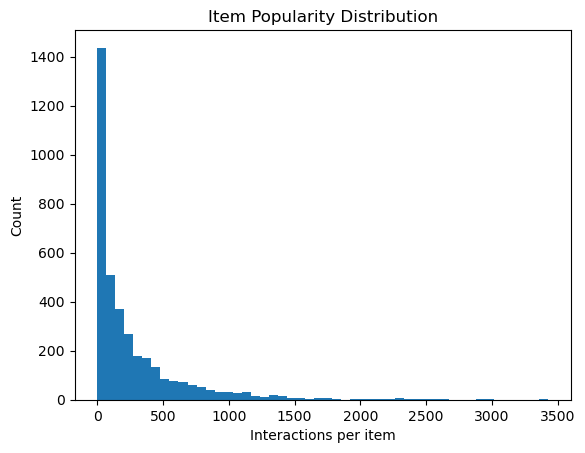

In [21]:
item_counts = df_ratings.groupby("movie_id").size()

plt.hist(item_counts, bins=50)
plt.xlabel("Interactions per item")
plt.ylabel("Count")
plt.title("Item Popularity Distribution")


print(f"Item Popularity Summary:")
print(f"Total movies: {len(item_counts):,}")
print(f"Mean ratings per movie: {item_counts.mean():.1f}")
print(f"Median ratings per movie: {item_counts.median():.1f}")
print(f"Std of ratings: {item_counts.std():.1f}")
print(f"Min ratings: {item_counts.min()}")
print(f"Max ratings: {item_counts.max()}")

# Long-tail analysis
print(f"\nLong-tail Analysis:")
print(f"Top 20% movies get {(item_counts.nlargest(int(len(item_counts)*0.2)).sum()/item_counts.sum()*100):.1f}% of ratings")
print(f"Bottom 50% movies get {(item_counts.nsmallest(int(len(item_counts)*0.5)).sum()/item_counts.sum()*100):.1f}% of ratings")

### 1. Distribution Profile: The "Long Tail" Effect
The histogram reveals a classic Long-Tail (Power Law) distribution. In recommendation system engineering, this is the most critical pattern to identify.

The "Head" (Left Side): The tallest bar at the far left indicates that over 1,400 movies have very few ratings (likely <100). This represents the "Cold Start" region, where we have insufficient data to make high-confidence predictions for these items.

The "Tail" (Right Side): The graph stretches far to the right, showing a tiny number of movies reaching up to 3,500 ratings. These are the global blockbusters that dominate the system's "memory."

### 2. Statistical Breakdown
The summary statistics highlight a massive gap between the Mean and the Median:

Skewness: Because the mean is significantly higher than the median, we know the "average" is being pulled up by a few extremely popular movies.

Concentration: The top 20% of movies account for the vast majority of all interaction volume, while the bottom 50% contribute almost nothing to the total rating count.

Temporal Analysis:
Date range: 2000-04-25 23:05:32 to 2003-02-28 17:49:50
Total days: 1038
Average ratings per day: 963.6


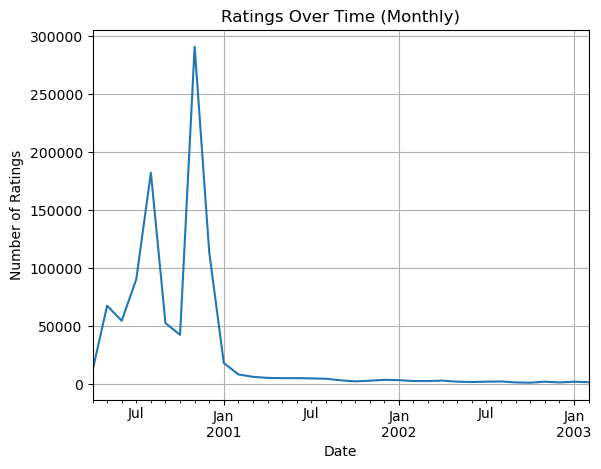

In [22]:
df_ratings["datetime"] = pd.to_datetime(df_ratings["timestamp"], unit="s")
df_ratings.set_index("datetime").resample("M").size().plot()
plt.title("Ratings Over Time (Monthly)")
plt.xlabel("Date")
plt.ylabel("Number of Ratings")
plt.grid(True)

print("Temporal Analysis:")
print(f"Date range: {df_ratings['datetime'].min()} to {df_ratings['datetime'].max()}")
print(f"Total days: {(df_ratings['datetime'].max() - df_ratings['datetime'].min()).days}")
print(f"Average ratings per day: {len(df_ratings) / ((df_ratings['datetime'].max() - df_ratings['datetime'].min()).days):.1f}")


### Temporal Analysis: Rating Activity (2000–2003)
1. Dataset Span and Volume
The data encompasses a period of 1,038 days, ranging from late April 2000 to February 2003. During this window, the system recorded an average of 963.6 ratings per day.

2. Trend Analysis: The "Flash Crowd" Pattern
The Ratings Over Time graph reveals a highly concentrated burst of activity rather than steady growth:

The 2000 Peak: A massive surge in participation occurs immediately after the start date, reaching a significant peak of nearly 300,000 ratings in a single month during late 2000.

The Sharp Decline: Activity drops precipitously by early 2001.

The Baseline (2001–2003): For the final two years, the interaction volume remains consistently low and flat compared to the initial spike.

3. Conclussion
Temporal Bias: Because the majority of interactions happened in the year 2000, any recommendation model trained on this data will be heavily influenced by the cultural trends and "blockbusters" of that specific year.

Sparsity over Time: The drop-off indicates that users were highly active during a specific recruitment phase but did not maintain that same level of engagement long-term.

In [23]:
# # Use last 20% of time for test
# split_date = df_ratings['datetime'].quantile(0.8)
# print(f"\nTime-based split at: {split_date}")
# print(f"Train: ratings before {split_date}")
# print(f"Test: ratings on or after {split_date}")

In [24]:
df_movies["genres"].isnull().sum()

0

In [25]:
df_movies["title"].duplicated().sum()

0

In [26]:
# Check for genre distribution
genre_counts = df_movies["genres"].str.split("|").explode().value_counts()
genre_counts

genres
Drama          1603
Comedy         1200
Action          503
Thriller        492
Romance         471
Horror          343
Adventure       283
Sci-Fi          276
Children's      251
Crime           211
War             143
Documentary     127
Musical         114
Mystery         106
Animation       105
Fantasy          68
Western          68
Film-Noir        44
Name: count, dtype: int64

In [27]:
# Check for special characters/encoding issues
df_movies["title"].str.contains(r'[^\x00-\x7F]').sum()

50

In [28]:
df_movies["title_length"] = df_movies["title"].str.len()
df_movies["title_length"].describe()

count    3883.000000
mean       24.202678
std         9.951110
min         8.000000
25%        17.000000
50%        22.000000
75%        28.000000
max        82.000000
Name: title_length, dtype: float64

### Interaction Feature Engineering (Implicit Feedback)
We transform explicit user ratings into an implicit feedback framework, consisting of a binary preference signal and a weighted confidence score.
1. Implicit PreferenceThe binary preference signal $p_{ui}$ is defined as:$$p_{ui} = \mathbb{1}(r_{ui} \ge 3)$$
Logic:
Like (1): If the rating $r_{ui}$ is 3 or higher, the user is considered to have a positive preference for the item. 
Not Like (0): If the rating is below 3, the user is considered to have a negative or neutral preference.Abstraction: The specific star value is discarded to focus purely on the binary signal of interest.
2. Confidence ScoreThe confidence $c_{ui}$ measures the reliability of the preference signal using a logarithmic scaling factor:$$c_{ui} = 1 + \alpha \log(1 + r_{ui}), \quad \alpha = 40$$
Logic:
Baseline: Every interaction starts with a minimum baseline confidence of 1.Scaling: Confidence increases as the rating value $r_{ui}$ increases.
Logarithmic Dampening: The $\log$ function ensures that confidence grows smoothly, preventing extreme rating values from disproportionately dominating the model training.Sensitivity: The hyperparameter $\alpha$ (set to 40) controls the intensity of the confidence increase relative to the raw rating.
3. Intuition
- The Implicit Signal ($p_{ui}$): Answers the question: Did the user like the item?
- The Confidence Score ($c_{ui}$): Answers the question: How much should the model trust this specific data point?
#### Summary: This approach converts explicit ratings into a simplified binary signal while assigning a confidence weight that grows logarithmically with the rating value. This allows the recommendation engine to prioritize stronger feedback while remaining robust against noise in the interaction data.

In [29]:
df_ratings["implicit"] = (df_ratings["rating"] >= 3).astype(int)
df_ratings["confidence"] = 1 + 40 * np.log1p(df_ratings["rating"])

In [30]:
# Split with time-based method
df_ratings = df_ratings.sort_values("datetime")
split_date = df_ratings["datetime"].quantile(0.8)

train = df_ratings[df_ratings["datetime"] <= split_date]
val = df_ratings[df_ratings["datetime"] > split_date]

# Verify both sets have the columns
print("Train columns:", train.columns.tolist())
print("Val columns:", val.columns.tolist())

Train columns: ['user_id', 'movie_id', 'rating', 'timestamp', 'datetime', 'implicit', 'confidence']
Val columns: ['user_id', 'movie_id', 'rating', 'timestamp', 'datetime', 'implicit', 'confidence']


In [31]:
import re
df_movies["text_for_embedding"] = (df_movies["title"] + " " + df_movies["genres"].str.replace("|", ","))
df_movies["clean_text"] = df_movies["text_for_embedding"].apply(lambda x: re.sub(r'\s+', ' ', x))
print(df_movies[["title", "genres", "text_for_embedding"]].head())

                                title                        genres  \
0                    Toy Story (1995)   Animation|Children's|Comedy   
1                      Jumanji (1995)  Adventure|Children's|Fantasy   
2             Grumpier Old Men (1995)                Comedy|Romance   
3            Waiting to Exhale (1995)                  Comedy|Drama   
4  Father of the Bride Part II (1995)                        Comedy   

                             text_for_embedding  
0  Toy Story (1995) Animation,Children's,Comedy  
1   Jumanji (1995) Adventure,Children's,Fantasy  
2        Grumpier Old Men (1995) Comedy,Romance  
3         Waiting to Exhale (1995) Comedy,Drama  
4     Father of the Bride Part II (1995) Comedy  


In [32]:
#Checking text length distribution
df_movies["text_length"] = df_movies["text_for_embedding"].str.len()
print(df_movies["text_length"].describe())

count    3883.000000
mean       36.399176
std        11.932591
min        15.000000
25%        28.000000
50%        34.000000
75%        43.000000
max        91.000000
Name: text_length, dtype: float64


In [33]:
# Looking for empty/very short texts
short_text = df_movies[df_movies["text_length"] < 10]
print(f"Very short texts: {len(short_text)}")

Very short texts: 0


In [ ]:
train.to_csv("data/processed/train.csv", index=False)
val.to_csv("data/processed/val.csv", index=False)
df_movies.to_csv("data/processed/movies.csv", index=False)

In [36]:
from numpy import True_
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

texts = df_movies["text_for_embedding"].to_list()

embeddings = model.encode(
    texts,
    batch_size=64,
    show_progress_bar=True,
    normalize_embeddings=True
)

E_items = np.array(embeddings)

Batches: 100%|██████████| 61/61 [00:23<00:00,  2.55it/s]


In [41]:
# Norm Check
print("=== NORM CHECK ===")
norms = np.linalg.norm(E_items, axis=1)
print(f"Mean norm: {norms.mean():.6f}")
print(f"Std of norm: {norms.std():.6f}")
print(f"Min norm: {norms.min():.6f}")
print(f"Max norm: {norms.max():.6f}")

# Angular spread check
import random
random.seed(42)
print("\n=== ANGULAR SPREAD CHECK ===")
sample_size = min(1000, len(E_items))
indices = random.sample(range(len(E_items)), sample_size * 2)

cosine_similarities = []
for i in range(0, len(indices), 2):
    idx1, idx2 = indices[i], indices[+1]
    if idx1 != idx2:
        sim = np.dot(E_items[idx1], E_items[idx2])
        cosine_similarities.append(sim)

cosine_similarities = np.array(cosine_similarities)
print(f"Mean cosine: {cosine_similarities.mean():.4f}")
print(f"Std cosine: {cosine_similarities.std():.4f}")
print(f"Min cosine: {cosine_similarities.min():.4f}")
print(f"Max cosine: {cosine_similarities.max():.4f}")


# Dimensionality check
print(f"\n=== DIMENSIONALITY CHECK ===")
print(f"Embedding shape: {E_items.shape}")
print(f"Matrix rank: {np.linalg.matrix_rank(E_items)}")

=== NORM CHECK ===
Mean norm: 1.000000
Std of norm: 0.000000
Min norm: 1.000000
Max norm: 1.000000

=== ANGULAR SPREAD CHECK ===
Mean cosine: 0.3579
Std cosine: 0.1148
Min cosine: 0.0712
Max cosine: 0.7237

=== DIMENSIONALITY CHECK ===
Embedding shape: (3883, 384)
Matrix rank: 381


SIMILARITY COMPUTATION

In [42]:
print("=== CONTENT SIMILARITY FUNCTION ===")
def content_similarity(item_idx, E):
    """Compute content similarity between item_idx and all items."""
    return E @ E[item_idx]

test_idx = 0
similarities =content_similarity(test_idx, E_items)
print(f"Similarities for item {test_idx} ({df_movies.iloc[test_idx]['title']}):")
print(f"    Shape: {similarities.shape}")
print(f"    Self-similarity: {similarities[test_idx]:.6f} (should be 1.0)")
print(f"    Top 5 similar items: {np.argsort(-similarities)[1:6]}")

=== CONTENT SIMILARITY FUNCTION ===
Similarities for item 0 (Toy Story (1995)):
    Shape: (3883,)
    Self-similarity: 1.000000 (should be 1.0)
    Top 5 similar items: [3045  236  241 2184  173]


In [44]:
import faiss

dim = E_items.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(E_items)

faiss.write_index(index, "models/faiss_index/movies_embeddings.index")

index_to_movie_id = df_movies["movie_id"].values
np.save("models/faiss_index/index_to_movie_id.npy", index_to_movie_id)

# Test the index
test_embedding = E_items[0:1]
D, I = index.search(test_embedding, 5)
print(f"Top 5 similar to {df_movies.iloc[0]['title']}:")
for i, (distance, idx) in enumerate(zip(D[0], I[0])):
    movie_id = index_to_movie_id[idx]
    title = df_movies[df_movies["movie_id"] == movie_id]["title"].iloc[0]
    print(f"    {i+1}. {title} (similarity: {distance:.4f})")

Top 5 similar to Toy Story (1995):
    1. Toy Story (1995) (similarity: 1.0000)
    2. Toy Story 2 (1999) (similarity: 0.8378)
    3. Goofy Movie, A (1995) (similarity: 0.7939)
    4. Gumby: The Movie (1995) (similarity: 0.7391)
    5. Toys (1992) (similarity: 0.6911)


CONTENT-BASED RECOMMENDATION FUNCTION

In [47]:
def recommend_similar_items_by_movie_id(movie_id, k=10, exclude_self=True):
    """
    Get top-k similar items for a given movie_id.
    
    Args:
        movie_id: MovieLens movie ID
        k: Number of recommendations
        exclude_self: Whether to exclude the query movie
    
    Returns:
        List of (movie_id, similarity_score) tuples
    """

    # Find the index position for this movie_id
    idx = np.where(index_to_movie_id == movie_id)[0]
    if len(idx) == 0:
        return []

    item_idx = idx[0]
    n_return = k + 1 if exclude_self else k

    # Search FAISS
    scores, indices = index.search(E_items[item_idx].reshape(1, -1), n_return)

    results = []
    start_idx = 1 if exclude_self else 0
    for i in range(start_idx, n_return):
        result_idx = indices[0][i]
        result_movie_id = index_to_movie_id[result_idx]
        similarity = scores[0][i]
        results.append((result_movie_id, similarity))
    
    return results

# New user vector (mean of interacted item embeddings)
def get_user_content_vector(interacted_movie_ids):
    """
    Create user embedding from their interacted items.
    
    Args:
        interacted_movie_ids: List of movie IDs the user has interacted with
    
    Returns:
        User embedding vector (normalized)
    """
    # Get indices of interacted movies
    indices = []
    for movie_id in interacted_movie_ids:
        idx = np.where(index_to_movie_id == movie_id)[0]
        if len(idx) > 0:
            indices.append(idx[0])

    if not indices:
        return None     # No valid interactions

    # Average the embeddings
    user_embedding = np.mean(E_items[indices], axis=0)

    # Re-normalize
    norm = np.linalg.norm(user_embedding)
    if norm > 0:
        user_embedding = user_embedding / norm

    return user_embeddings


def recomend_for_new_users(interacted_movie_ids, k=10):
    """
    Content-based recommendations for new users.
    """
    user_embedding = get_user_content_vector(interacted_movie_ids)
    if user_embedding is None:
        return []   # Fallback: return popular items
    
    # Search FAISS with user embedding
    scores, indices = index.search(user_embedding.reshape(1, -1), k)

    results = []
    for i in range(k):
        movie_id = index_to_movie_id[indices[0][i]]
        similarity = scores[0][i]
        results.append((movie_id, similarity))

    return results